# VGG16

In [ ]:
!rm -f /kaggle/working/model_*

In [3]:
import numpy as np
import torch as tr
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import AdamW, SGD
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.init as init 
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import sys
sys.path.insert(1, '/kaggle/input/ferdata-set')
from FERData import FERDataset

from glob import glob

# Device configuration
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')

In [4]:
kaggle_path = '/kaggle/input/fer2013-custom'

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

train_dataset = FERDataset(kaggle_path + '/dataset/train', transform = train_transforms)
val_dataset = FERDataset(kaggle_path + '/dataset/val', transform = val_transforms)
test_dataset =  FERDataset(kaggle_path + '/dataset/test', transform = val_transforms)

In [5]:
batch_size = 16
train_dataLoader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataLoader = DataLoader(test_dataset, batch_size, shuffle=True)

val_dataLoader = DataLoader(val_dataset, batch_size, shuffle= True)

In [6]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def initialize_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0.0)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [7]:
def train(dataLoader, model, optimizer, lossf, lr_scheduler=None):
    model.train()
    losses = []
    total = 0
    correct = 0
    t = 0
    
    for img, label in dataLoader:
        t += 1
        t_imgs = img.to(device, dtype=tr.float)
        t_labels = label.to(device, dtype=tr.int64)
        
        optimizer.zero_grad()
        
        prediction = model(t_imgs)
        loss = lossf(prediction, t_labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        _, predicted = tr.max(prediction, 1)
        total += t_labels.size(0)
        correct += (predicted == t_labels).sum().item()
        
        if t % 16 == 0:
            print('|', end='')
    
    train_loss = np.average(losses)
    train_acc = 100.0 * correct / total
    
    print('Train loss is %.3f' % train_loss)
    print('In %d pictures, %d are predicted right' % (total, correct))
    print('Training acc is %.4f%%' % train_acc)
    
    return


In [8]:
def test(dataLoader, model, lossf):
  model.eval()
  losses, predictions, labels = np.array([]), np.array([]), np.array([])
  result = []

  for img, label in dataLoader:

    t_imgs = img.to(device, dtype=tr.float)
    t_labels = label.to(device, dtype=tr.int64)
    labels = np.append(labels, t_labels.cpu())

    output = model(t_imgs)
    _, prediction = tr.max(output, 1)
    predictions = np.append(predictions, prediction.cpu())

    #create result
    result.append(list(zip(img, label, prediction.cpu())))

    loss = lossf(output, t_labels)
    losses = np.append(losses, loss.item())

  return np.average(losses), predictions, labels, result

In [9]:
def val(dataLoader, model, lossf):
    model.eval()
    losses, predictions, labels = [], [], []
    result = []

    total = 0
    correct = 0

    for img, label in dataLoader:
        t_imgs = img.to(device, dtype=tr.float)
        t_labels = label.to(device, dtype=tr.int64)
        labels.extend(t_labels.cpu().tolist())

        with tr.no_grad():
            output = model(t_imgs)
            _, prediction = tr.max(output, 1)
            predictions.extend(prediction.cpu().tolist())

        # Create result
        result.extend(list(zip(img, label, prediction.cpu().numpy())))

        loss = lossf(output, t_labels)
        losses.append(loss.item())

        total += t_labels.size(0)
        correct += (prediction ==  t_labels).sum().item()

    test_acc = 100.0 * correct / total

    print('One test epoch is over')
    print('In %d pictures, %d are predicted right' % (total, correct))
    print('Validation acc is %.4f%%' % test_acc)

    return sum(losses)/len(losses), predictions, labels, result


In [10]:
def run(train_dataLoader, val_dataLoader, model, optimizer, lossf, lr_scheduler=None, epochs=50):
    es_counter = 0  # counter early stopping
    es_limit = 100  # epoch limit for early stopping

    best_model = model
    best_epoch = None
    min_avgLosses = float('inf')

    for epoch in range(epochs):
        train(train_dataLoader, model, optimizer, lossf, lr_scheduler)

        val_avgLosses, _, _, _ = val(val_dataLoader, model, lossf)
        print(f'Epoch {epoch} - Validation Loss: {val_avgLosses}')

        if val_avgLosses < min_avgLosses:
            min_avgLosses = val_avgLosses
            best_epoch = epoch
            best_model = model
            es_counter = 0
        else:
            es_counter += 1

        if es_counter > es_limit - 1:
            print('---- EARLY STOPPING -----')
            break

    print(f'---> Best epoch: {best_epoch}')
    return best_model, min_avgLosses


In [ ]:
def load_checkpoint(filepath, phase):
    
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    
    if phase == 'test':
        for parameter in model.parameters():
            parameter.requires_grad = False

        model.eval()
    
    return model

In [14]:
model = VGG16(7).to(device)
model.apply(model.initialize_weights)
# set if you want best last trained model
best_model_flag = True
if best_model_flag:
    models_list = glob('/kaggle/input/model-1/model_*')
    if models_list:
        best_last_model = sorted(models_list)[0]
        model.load_state_dict(tr.load(best_last_model).state_dict())
        print(f'{best_last_model} caricato!')
    else:
        print('Errore nel recupero del modello')
else:
  print('Caricato modello Vanilla!')

optimizer = SGD(model.parameters(),lr = 0.0001, momentum=0.9, weight_decay=5e-4)
lossf = nn.CrossEntropyLoss()

epochs = 50

#lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs*len(train_dataLoader), eta_min=0)

best_model, min_avgLosses = run(train_dataLoader, val_dataLoader, model, optimizer, lossf,lr_scheduler=None, epochs=epochs)

checkpoint = {'model': VGG16(7),
              'state_dict': best_model.state_dict(),
              'optimizer' : optimizer.state_dict()}

tr.save(checkpoint, f'checkpoint_{min_avgLosses}.pth')

/kaggle/input/model-1/model_1.0309 caricato!


KeyboardInterrupt: 

In [15]:
best_model_flag = True
if best_model_flag:
    models_list = glob('/kaggle/input/model-1/model_*')
    if models_list:
        best_last_model = sorted(models_list)[0]
        model.load_state_dict(tr.load(best_last_model).state_dict())
        print(f'{best_last_model} caricato!')
    else:
        print('Errore nel recupero del modello')

/kaggle/input/model-1/model_1.0309 caricato!


In [27]:
#carico il miglior modello dal train nel modello attuale
#model.load_state_dict(best_model.state_dict())

val_avgLosess, val_predictions, val_labels, val_result = val(val_dataLoader, model, lossf)
print(classification_report(val_labels, val_predictions, digits=4))

One test epoch is over
In 2868 pictures, 1715 are predicted right
Validation acc is 59.7978%
              precision    recall  f1-score   support

           0     0.7492    0.7256    0.7372       317
           1     0.5179    0.2836    0.3665       409
           2     0.6571    0.4035    0.5000       399
           3     0.5905    0.5262    0.5565       496
           4     0.3843    0.7391    0.5057       483
           5     0.6000    0.2791    0.3810        43
           6     0.8245    0.8017    0.8129       721

    accuracy                         0.5980      2868
   macro avg     0.6176    0.5370    0.5514      2868
weighted avg     0.6312    0.5980    0.5948      2868



In [28]:
#carico il miglior modello dal train nel modello attuale
#model.load_state_dict(best_model)

test_avgLosess, test_predictions, test_labels, test_result = test(test_dataLoader, model, lossf)
print(classification_report(test_labels, test_predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.7385    0.7341    0.7363       831
         1.0     0.5067    0.2598    0.3434      1024
         2.0     0.6120    0.4165    0.4957       958
         3.0     0.5887    0.5061    0.5443      1233
         4.0     0.3804    0.7322    0.5007      1247
         5.0     0.6571    0.4144    0.5083       111
         6.0     0.8450    0.7835    0.8131      1774

    accuracy                         0.5918      7178
   macro avg     0.6183    0.5495    0.5631      7178
weighted avg     0.6257    0.5918    0.5897      7178



In [63]:
#@title
import matplotlib.pyplot as plt
print(test_result[1][1])

def plot_figure(test_result):
  fig, ax = plt.subplots(6, 6)
  for i, axi in enumerate(ax.flat):
    img, lb, pr = test_result[1][i]
    axi.imshow(img.reshape(3, 224, 224), cmap='gray')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(f'{lb} - P:{pr}',
                    color='black' if lb == pr else 'red')
  fig.suptitle('Predicted Emotion; Incorrect Labels in Red', size=14);

NameError: name 'test_result' is not defined

TypeError: Invalid shape (3, 224, 224) for image data

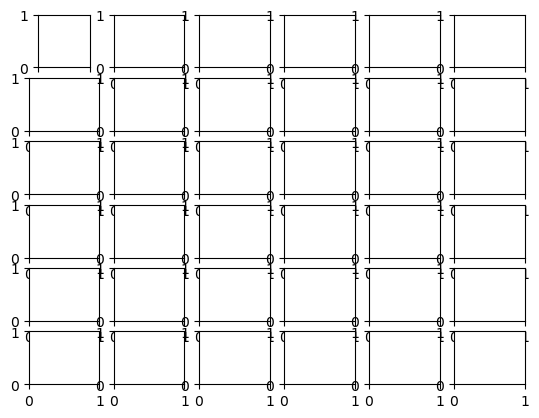

In [40]:
plot_figure(test_result)

In [45]:
#@title
from sklearn.metrics import confusion_matrix
def get_confusion_matrix(test_labels, test_predictions, labels):

  mat = confusion_matrix(test_labels, test_predictions)
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=labels,
              yticklabels=labels)
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.title(best_last_model if best_last_model else 'First Model')

{'surprise': 0, 'fear': 1, 'angry': 2, 'neutral': 3, 'sad': 4, 'disgust': 5, 'happy': 6}


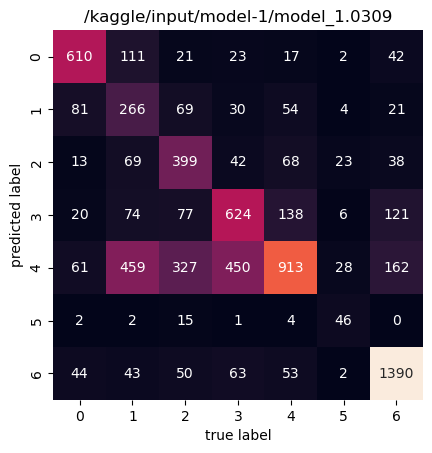

In [46]:
labels = test_dataset.labels.values()
get_confusion_matrix(test_labels, test_predictions, labels)
print(test_dataset.labels)

In [37]:
from PIL import Image
import cv2

In [89]:
def doSomeMagic(image_path : str, model):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path)
    processed_image = transform(image)

    input_image = processed_image.unsqueeze(0)  # Add a batch dimension

    # Perform inference
    with tr.no_grad():
        output = model(input_image.to(device))

    # Interpret the results
    predicted_class = tr.argmax(output, dim=1).item()
    getLabel = lambda value: next((key for key, val in train_dataset.labels.items() if val == value), None)
    predicted_label =  getLabel(predicted_class)
    
    plt.title(predicted_label)
    plt.imshow(image)